In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

# Load Meanbrain

In [34]:
file = os.path.join(root_directory,
                    '2019_nov_meanbrain',
                    'meanbrain_final.nii')

meanbrain = bbb.load_numpy_brain(file)

# Reset master spacing

meanbrain = ants.from_numpy(meanbrain)
anatomy_xml = os.path.join(root_directory, 'fly_25', 'anat_0', 'anatomy.xml')
meanbrain.set_spacing(bbb.get_resolution(anatomy_xml))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 261.94 ms


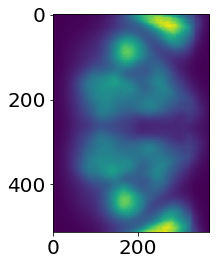

In [17]:
plt.imshow(master.numpy()[:,:,200])

# Load Template

In [6]:
template_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central', 'meanbrain1', 'JFRCtemplate2010.nii')
template = bbb.load_numpy_brain(template_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 667.95 ms


In [12]:
# Flip Z-axis
template = template[:,:,::-1]

In [29]:
# Cut off optic lobes
template = template[200:800,:,:]

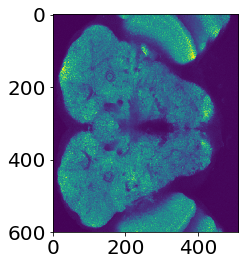

In [30]:
plt.imshow(template[:,:,80])

In [32]:
# Set resolution
template = ants.from_numpy(template)
ants.set_spacing(template, (0.622, 0.622, 0.622))

# Warp

In [36]:
master = meanbrain
slave = template

print('Started...')
t0 = time.time()
slave2master = ants.registration(master,slave,type_of_transform='SyN')
print('COMPLETE. Duration: {:0.0f} sec'.format(time.time()-t0))

Started...
COMPLETE. Duration: 204 sec


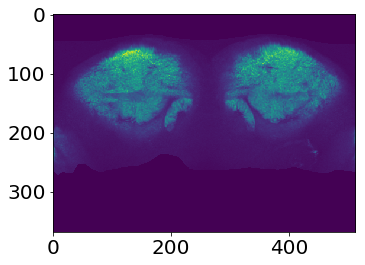

In [42]:
plt.imshow(slave2master['warpedmovout'][:,:,70].T)

In [44]:
save_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/2019_nov_meanbrain/template alignment/'

In [45]:
file = os.path.join(save_folder, 'template2mean.nii')
bbb.save_brain(file, slave2master['warpedmovout'].numpy())


~~ save_brain ~~
Current memory usage: 2.35GB
save_brain done. Duration: 415.23 ms


In [ ]:
# Looks excellent in most places, but a few failures.
# Most notably, PB is slightly off.
# Also MB issues.

# Use warp params on ROIs

In [46]:
file = 'JFRCtempate2010.mask130819_Original.nii'
roi_file = template_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central',
                                        'meanbrain1',
                                         file)
roi = bbb.load_numpy_brain(template_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 620.31 ms


In [47]:
# Flip Z-axis
roi = roi[:,:,::-1]

In [48]:
# Cut off optic lobes
roi = roi[200:800,:,:]

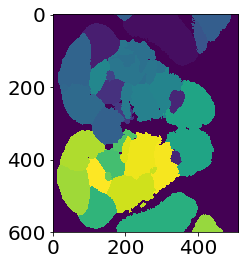

In [49]:
plt.imshow(roi[:,:,80])

In [50]:
roi = ants.from_numpy(roi)
ants.set_spacing(roi, (0.622, 0.622, 0.622))

In [51]:
roi_warped = ants.apply_transforms(meanbrain,
                                   roi,
                                   slave2master['fwdtransforms'],
                                   interpolator='genericLabel')

In [61]:
template2mean = slave2master

In [52]:
roi_warped

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 368, 251)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [53]:
file = os.path.join(save_folder, 'roi2mean.nii')
bbb.save_brain(file, roi_warped.numpy())


~~ save_brain ~~
Current memory usage: 2.81GB
save_brain done. Duration: 612.48 ms


# Warp roi into a single fly brain

#### Load anatomy

In [65]:
anatomy_file = os.path.join(root_directory, 'fly_1','anat_0','anatomy.nii')
anatomy = bbb.load_numpy_brain(anatomy_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 269.94 ms


In [66]:
anatomy = np.swapaxes(anatomy,0,1)

In [67]:
anatomy = ants.from_numpy(anatomy)
anatomy_xml = os.path.join(root_directory, 'fly_1', 'anat_0', 'anatomy.xml')
anatomy.set_spacing(bbb.get_resolution(anatomy_xml))

#### Warp meanbrain to anatomy

In [68]:
master = anatomy
slave = meanbrain

print('Started...')
t0 = time.time()
mean2anat = ants.registration(master,slave,type_of_transform='SyN')
print('COMPLETE. Duration: {:0.0f} sec'.format(time.time()-t0))

Started...
COMPLETE. Duration: 309 sec


#### Apply template2mean tranforms, then mean2anat transforms

In [86]:
master = meanbrain
slave = roi

roi2mean = ants.apply_transforms(master,
                                   slave,
                                   template2mean['fwdtransforms'],
                                   interpolator='genericLabel')

In [87]:
master = anatomy
slave = roi2mean

roi2anat = ants.apply_transforms(master,
                                 slave,
                                 mean2anat['fwdtransforms'],
                                 interpolator='genericLabel')

In [88]:
file = os.path.join(save_folder, 'roi2anat(fly_1).nii')
bbb.save_brain(file, roi2anat.numpy())


~~ save_brain ~~
Current memory usage: 4.24GB
save_brain done. Duration: 555.78 ms


#### for sanity save correctly rotated anat

In [72]:
file = os.path.join(save_folder, 'anat(fly_1).nii')
bbb.save_brain(file, anatomy.numpy())


~~ save_brain ~~
Current memory usage: 4.05GB
save_brain done. Duration: 413.38 ms


# Current state: Honestly everything is probably good enough except PB. Failure is definitely template to mean. Try different alignment parameters, smoothing, etc.

# Fresh work session here. Try to improve PB

In [89]:
plt.rcParams.update({'font.size': 20})

In [90]:
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

# Load Meanbrain

In [91]:
file = os.path.join(root_directory,
                    '2019_nov_meanbrain',
                    'meanbrain_final.nii')

meanbrain = bbb.load_numpy_brain(file)

# Reset master spacing

meanbrain = ants.from_numpy(meanbrain)
anatomy_xml = os.path.join(root_directory, 'fly_25', 'anat_0', 'anatomy.xml')
meanbrain.set_spacing(bbb.get_resolution(anatomy_xml))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 407.35 ms


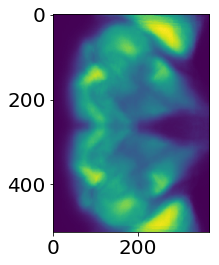

In [95]:
plt.imshow(meanbrain.numpy()[:,:,150])

# Load Template

In [96]:
template_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central', 'meanbrain1', 'JFRCtemplate2010.nii')
template = bbb.load_numpy_brain(template_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 958.99 ms


In [97]:
# Flip Z-axis
template = template[:,:,::-1]

In [98]:
# Cut off optic lobes
template = template[200:800,:,:]

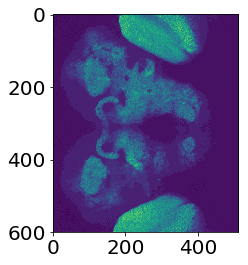

In [130]:
plt.imshow(np.around(template[:,:,40],decimals=-1))

In [100]:
# Set resolution
template = ants.from_numpy(template)
ants.set_spacing(template, (0.622, 0.622, 0.622))

# Try decreasing meanbrain contrast, since their patterns don't match anyway

In [189]:
meanbrain_n4 = ants.n4_bias_field_correction(meanbrain)

In [ ]:
template_n4 = ants.n4_bias_field_correction(template)

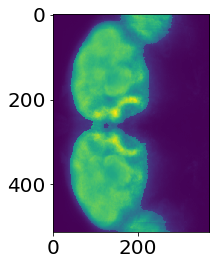

In [204]:
plt.imshow(meanbrain_n4.numpy()[:,:,80])

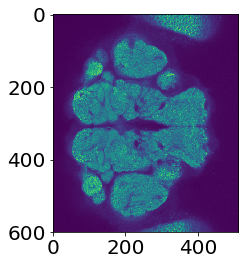

In [202]:
plt.imshow(template_n4.numpy()[:,:,150])

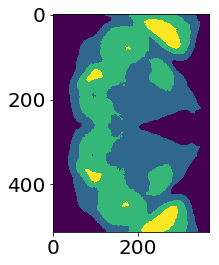

In [135]:
plt.imshow(np.around(meanbrain.numpy()[:,:,150],decimals = -3),vmin=0,vmax=3000)

#### First, normalize-ish slice intensity

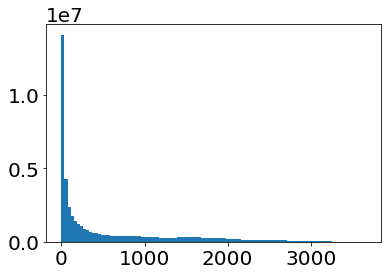

In [109]:
plt.hist(np.ndarray.flatten(meanbrain.numpy()),bins=100);

In [ ]:
for z in range(meanbrain.numpy().shape[-1]):
    

In [160]:
a = 2
b = 0
depth_correction = np.arange(0,meanbrain.numpy().shape[-1])
print(depth_correction)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [185]:
test = np.add(meanbrain.numpy(), depth_correction*5)

In [186]:
thresh = 1900
high = test > thresh
low = test <=thresh

test[high] = 1
test[low] = 0

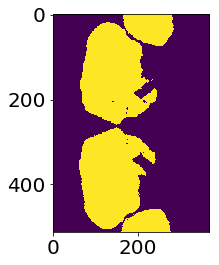

In [187]:
plt.imshow(test[:,:,93])

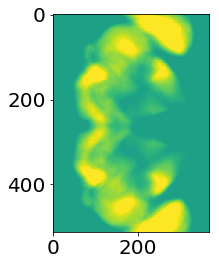

In [178]:
plt.imshow(np.clip(test[:,:,150],1700,3000),vmin=0,vmax=3000)

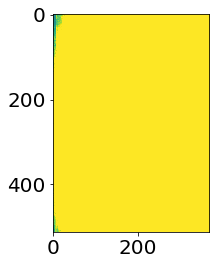

In [150]:
plt.imshow(np.clip(test[:,:,150],1500,3000),vmin=0,vmax=3000)

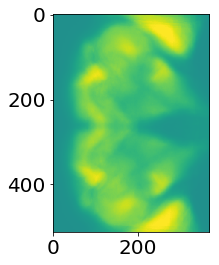

In [117]:
contrast = 0.5
plt.imshow(contrast*meanbrain.numpy()[:,:,150] + 1500,vmin=0,vmax=3000)

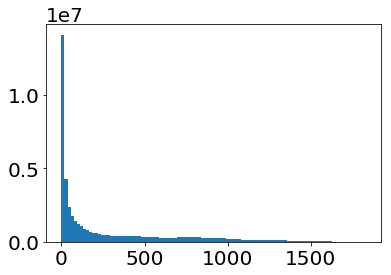

In [111]:
plt.hist(0.5*np.ndarray.flatten(meanbrain.numpy()),bins=100);

In [ ]:
min_value = 500
max_value = 

# Warp

In [209]:
master = meanbrain_n4
slave = template_n4

print('Started...')
t0 = time.time()
slave2master = ants.registration(master,
                                 slave,
                                 type_of_transform='SyN')
print('COMPLETE. Duration: {:0.0f} sec'.format(time.time()-t0))

Started...
COMPLETE. Duration: 207 sec


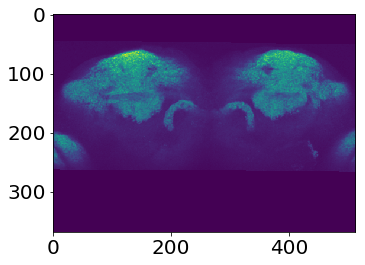

In [102]:
plt.imshow(slave2master['warpedmovout'][:,:,70].T)

In [200]:
save_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/2019_nov_meanbrain/template alignment/'

In [210]:
file = os.path.join(save_folder, 'template2mean_n4_SyN.nii')
bbb.save_brain(file, slave2master['warpedmovout'].numpy())


~~ save_brain ~~
Current memory usage: 9.92GB
save_brain done. Duration: 1.28 sec


In [208]:
file = os.path.join(save_folder, 'template_n4.nii')
bbb.save_brain(file, template_n4.numpy())


~~ save_brain ~~
Current memory usage: 10.00GB
save_brain done. Duration: 708.56 ms


In [ ]:
# Looks excellent in most places, but a few failures.
# Most notably, PB is slightly off.
# Also MB issues.

# Use warp params on ROIs

In [211]:
file = 'JFRCtempate2010.mask130819_Original.nii'
roi_file = template_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central',
                                        'meanbrain1',
                                         file)
roi = bbb.load_numpy_brain(template_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 638.86 ms


In [212]:
# Flip Z-axis
roi = roi[:,:,::-1]

In [213]:
# Cut off optic lobes
roi = roi[200:800,:,:]

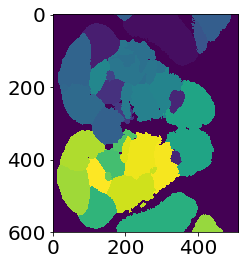

In [214]:
plt.imshow(roi[:,:,80])

In [215]:
roi = ants.from_numpy(roi)
ants.set_spacing(roi, (0.622, 0.622, 0.622))

In [216]:
roi_warped = ants.apply_transforms(meanbrain,
                                   roi,
                                   slave2master['fwdtransforms'],
                                   interpolator='genericLabel')

In [217]:
template2mean = slave2master

In [52]:
roi_warped

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 368, 251)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [218]:
file = os.path.join(save_folder, 'roi2mean_n4.nii')
bbb.save_brain(file, roi_warped.numpy())


~~ save_brain ~~
Current memory usage: 10.38GB
save_brain done. Duration: 417.16 ms


# Using better aligned template2mean, warp rois onto individuals

In [220]:
template2mean = slave2master

In [ ]:
for anat in anatomy_warps:
    save_folder = os.path.join(root_directory, anat, 'anat_0', 'warps_20191105')
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    transforms = anatomy_warps[anat]['fwdtransforms']
    for transform in transforms:
        transform_file = os.path.split(transform)[-1]
        save_file = os.path.join(save_folder, transform_file)
        print('save_file: {}'.format(save_file))
        print('Copying from {} to {}'.format(transform, save_file))
        shutil.copy(transform, save_file)

In [ ]:
template2mean['fwdtransforms']

In [ ]:
3

In [ ]:
save_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/2019_nov_meanbrain/template alignment/template2mean_transforms'
for transform in template2mean['fwdtransforms']:
    transform_file = os.path.split(transform)[-1]
    save_file = os.path.join(save_folder, transform_file)
    print('save_file: {}'.format(save_file))
    print('Copying from {} to {}'.format(transform, save_file))
    shutil.copy(transform, save_file)

In [ ]:
os.mkdir(save_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/2019_nov_meanbrain/template alignment/template2mean_transforms')

### Quick sanity test - can we load and use template2mean warp params?

In [233]:
affine_warp = ants.read_transform(template2mean['fwdtransforms'][-1]).parameters
nonlinear_warp = ants.from_numpy(bbb.load_numpy_brain(template2mean['fwdtransforms'][0]))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 5.53 sec


In [247]:
transforms = [template2mean['fwdtransforms'][0], template2mean['fwdtransforms'][-1]]

In [246]:
transforms

['/tmp/tmpr0_i0ogr1Warp.nii.gz',
 array([ 9.14360166e-01,  1.64364837e-02,  6.01343403e-04, -1.39264483e-02,
         9.56545234e-01,  6.11250520e-01,  3.95638839e-04, -3.04184794e-01,
         6.40365481e-01, -8.65915012e+00,  3.04219818e+00, -7.97755051e+01])]

In [236]:
template_file = os.path.join(save_folder, 'template_n4.nii')
template_n4 = ants.from_numpy(bbb.load_numpy_brain(template_file))
ants.set_spacing(template_n4, (0.622, 0.622, 0.622))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 1.68 sec


In [ ]:
template2mean_retransformed = ants.apply_transforms(fixed = meanbrain_n4,
                                                    moving = template_n4,
                                                    transformlist = transforms,
                                                    interpolator='genericLabel')

In [243]:
transforms

[ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 368, 251, 3)
 	 Spacing    : (1.0, 1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.],
 array([ 9.14360166e-01,  1.64364837e-02,  6.01343403e-04, -1.39264483e-02,
         9.56545234e-01,  6.11250520e-01,  3.95638839e-04, -3.04184794e-01,
         6.40365481e-01, -8.65915012e+00,  3.04219818e+00, -7.97755051e+01])]

In [229]:
for i in template2mean['fwdtransforms']:
    print(i)

/tmp/tmpr0_i0ogr1Warp.nii.gz
/tmp/tmpr0_i0ogr0GenericAffine.mat


In [223]:
out = bbb.load_numpy_brain(template2mean['fwdtransforms'][0])


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 5.64 sec


### Load anat2mean warps

In [ ]:
flies = ['fly_1',
         'fly_3',
         'fly_5',
         'fly_7',
         'fly_19',
         'fly_21',
         'fly_48',
         'fly_51',
         'fly_54',
         'fly_68']

warps = {}

for fly in flies:
    warp_file = os.path.join(root_directory, fly, 'anat_0', 'warps', 'anat2mean_2019nov.npy')
    

#### Load anatomy

In [65]:
anatomy_file = os.path.join(root_directory, 'fly_1','anat_0','anatomy.nii')
anatomy = bbb.load_numpy_brain(anatomy_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 269.94 ms


In [66]:
anatomy = np.swapaxes(anatomy,0,1)

In [67]:
anatomy = ants.from_numpy(anatomy)
anatomy_xml = os.path.join(root_directory, 'fly_1', 'anat_0', 'anatomy.xml')
anatomy.set_spacing(bbb.get_resolution(anatomy_xml))

#### Warp meanbrain to anatomy

In [68]:
master = anatomy
slave = meanbrain

print('Started...')
t0 = time.time()
mean2anat = ants.registration(master,slave,type_of_transform='SyN')
print('COMPLETE. Duration: {:0.0f} sec'.format(time.time()-t0))

Started...
COMPLETE. Duration: 309 sec


#### Apply template2mean tranforms, then mean2anat transforms

In [86]:
master = meanbrain
slave = roi

roi2mean = ants.apply_transforms(master,
                                   slave,
                                   template2mean['fwdtransforms'],
                                   interpolator='genericLabel')

In [87]:
master = anatomy
slave = roi2mean

roi2anat = ants.apply_transforms(master,
                                 slave,
                                 mean2anat['fwdtransforms'],
                                 interpolator='genericLabel')

In [88]:
file = os.path.join(save_folder, 'roi2anat(fly_1).nii')
bbb.save_brain(file, roi2anat.numpy())


~~ save_brain ~~
Current memory usage: 4.24GB
save_brain done. Duration: 555.78 ms


#### for sanity save correctly rotated anat

In [72]:
file = os.path.join(save_folder, 'anat(fly_1).nii')
bbb.save_brain(file, anatomy.numpy())


~~ save_brain ~~
Current memory usage: 4.05GB
save_brain done. Duration: 413.38 ms
